In [1]:
import json
import os
from datetime import datetime

import pandas as pd
import torch
from torch.utils.data import DataLoader

from datasets.SlideSeperatedCSVDataset import SlideSeperatedCSVDataset
from extractors.TemplateMatchExtractor import TemplateMatchExtractor, generate_dataset_from_slides
from labelers.GroundTruthLabeler import GroundTruthLabeler
from models.mlp import MLPBinaryClassifier
from models.resnet import Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier
from test import test_classifier
from train import train_classifier
from utils import extract_features_from_dataset
from utils import plot_model_metrics
from utils import split_dataset


In [2]:
slides_root_dir = "data/whole-slides/gut"
labels_root_dir = "data/labels"
candidates_dataset_dir = "output/candidates"
model_output_dir = "output/models"
PretrainedModelClass = Resnet101BinaryClassifier
pretrained_model_name = PretrainedModelClass.get_pretrained_model_name()
pretrained_output_size = PretrainedModelClass.pretrained_output_size
features_csv_file_name = f"{PretrainedModelClass.get_pretrained_model_name()}_{pretrained_output_size}_features.csv"
print(f"{pretrained_model_name}: {pretrained_output_size} features")

Resnet101: 2048 features


In [3]:
ground_truth_labeler = GroundTruthLabeler(f"{labels_root_dir}/slide-annotations/all.json",
                                          f"{labels_root_dir}/patch-classifications.csv")
extractor = TemplateMatchExtractor(ground_truth_labeler)
generate_dataset_from_slides(slides_root_dir, extractor, candidates_dataset_dir)

Found cached candidates dataset output/candidates


In [4]:
extract_features_from_dataset(candidates_dataset_dir,
                              [Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier])

Device: cuda:0
Found cached output/candidates/Resnet18_512_features.csv
Found cached output/candidates/Resnet50_2048_features.csv
Found cached output/candidates/Resnet101_2048_features.csv


In [5]:
def split_data(dataframe, train_portion=0.7):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for category in dataframe['quartile'].unique():
        category_slides = dataframe[dataframe['quartile'] == category]
        train_samples = category_slides.sample(frac=train_portion)
        test_samples = category_slides.drop(train_samples.index)
        train_set = pd.concat([train_set, train_samples])
        test_set = pd.concat([test_set, test_samples])
    return train_set, test_set


if os.path.exists("output/models/data-split.json"):
    with open(f"{model_output_dir}/data-split.json", 'r') as f:
        backup = json.load(f)
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = set(backup["train_slides"]), set(backup["test_slides"])
    if train_slides.union(test_slides) != set(slides_df["slide_name"]) or len(
            train_slides.intersection(test_slides)) > 0:
        raise ValueError("Invalid train test split")
    train_slides = slides_df[slides_df['slide_name'].isin(train_slides)]
    test_slides = slides_df[slides_df['slide_name'].isin(test_slides)]
else:
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = split_data(slides_df)
    with open(f"{model_output_dir}/data-split.json", 'w') as f:
        json.dump({
            "train_slides": list(train_slides["slide_name"]),
            "test_slides": list(test_slides["slide_name"])
        }, f)

print("Train Slides")
train_slides

Train Slides


,slide_name,n_gt_positive_regions,category
0,593444,31,2
2,593452,336,4
3,593445,107,4
4,593438,92,3
5,593441,4,1
6,593454,22,2
9,593451,1,1
10,593448,13,1
12,593433,3,1
14,593440,85,3


In [6]:
print("Test Slides")
test_slides

Test Slides


,slide_name,n_gt_positive_regions,category
1,593435,109,4
7,593434,27,2
8,593453,19,2
11,522021,3,1
13,593437,94,3
15,593436,170,4
21,593446,15,1


In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 4096
# dataset = SlideSeperatedImageDataset(candidates_dataset_dir, set(train_slides["slide_name"]))
dataset = SlideSeperatedCSVDataset(f"{candidates_dataset_dir}/{features_csv_file_name}",
                                   set(train_slides["slide_name"]))
# dataset = reduce_dataset(dataset, discard_ratio=0.0)

print(f"All dataset: {int(sum(dataset.labels)):,} positive, {len(dataset.labels):,} negative")


Device: cuda:0
All dataset: 702 positive, 71,534 negative


In [8]:
train_dataset, validation_dataset = split_dataset(dataset, train_ratio=0.9)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=True, )
print(f"Dataset: {len(train_dataset):,} training, {len(validation_dataset):,} validation")
print(f"Training: {int(sum(train_dataset.labels)):,d} positive, {len(train_dataset.labels):,} negative")
print(f"Validation: {int(sum(validation_dataset.labels)):,d} positive, {len(validation_dataset.labels):,} negative")

Dataset: 64,380 training, 7,154 validation
Training: 632 positive, 64,380 negative
Validation: 70 positive, 7,154 negative


In [9]:
# (hidden_layers=1, units=2048, dropout=0.1, threshold=0.5, learning_rate=3e-05, weight_decay=0.0, focal_alpha=0.75, focal_gamma=2.5)
model = MLPBinaryClassifier(in_features=pretrained_output_size, hidden_layers=1,
                            units_per_layer=2048,
                            dropout=0.1, focal_alpha=0.75, focal_gamma=2.5)

print(model)

MLPBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2048, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [10]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-02-09T16:37:33.329491


In [11]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, validation_loader, device,
                                        start_learning_rate=0.000030,
                                        min_learning_rate=0.000010,
                                        lr_warmup_steps=10,
                                        max_epochs=30,
                                        checkpoint_every=1,
                                        eval_every=1,
                                        early_stopper=None  #EarlyStopper(patience=5, min_delta=1e-4))
                                        )

Epoch 1 training: 100%|██████████| 16/16 [00:02<00:00,  7.41it/s]


Train: 1/30: lr: 0.000030000000 loss:0.013541793217882514


Epoch 1 testing: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Test: 1/30: loss:0.007349645486101508, accuracy:0.9902120207243297, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.21496360003948212, pr_auc:0.013870093274202284, epoch:1


Epoch 2 training: 100%|██████████| 16/16 [00:01<00:00,  8.20it/s]


Train: 2/30: lr: 0.000030000000 loss:0.007421747897751629


Epoch 2 testing: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Test: 2/30: loss:0.006221224088221788, accuracy:0.9901705854776406, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.20694496482610703, pr_auc:0.06080972918785697, epoch:2


Epoch 3 training: 100%|██████████| 16/16 [00:02<00:00,  7.73it/s]


Train: 3/30: lr: 0.000030000000 loss:0.006048187700798735


Epoch 3 testing: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Test: 3/30: loss:0.0054242846090346575, accuracy:0.9899219739975065, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.2193053662776947, pr_auc:0.1564784111324533, epoch:3


Epoch 4 training: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Train: 4/30: lr: 0.000030000000 loss:0.005158171697985381


Epoch 4 testing: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Test: 4/30: loss:0.004491319181397557, accuracy:0.9904606322044637, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.18596450239419937, pr_auc:0.18488709768050685, epoch:4


Epoch 5 training: 100%|██████████| 16/16 [00:02<00:00,  7.90it/s]


Train: 5/30: lr: 0.000030000000 loss:0.004564914182992652


Epoch 5 testing: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Test: 5/30: loss:0.004071370232850313, accuracy:0.9901705854776406, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.17808900028467178, pr_auc:0.22920533000643467, epoch:5


Epoch 6 training: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


Train: 6/30: lr: 0.000030000000 loss:0.004165113248745911


Epoch 6 testing: 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Test: 6/30: loss:0.003773463307879865, accuracy:0.9901705854776406, precision:0.25, recall:0.01282051282051282, f1:0.024390243902439022, mcc:0.05581567900877227, ece:0.15233194082975388, pr_auc:0.21984069775712362, epoch:6


Epoch 7 training: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]


Train: 7/30: lr: 0.000030000000 loss:0.003929197555407882


Epoch 7 testing: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Test: 7/30: loss:0.0035787696251645684, accuracy:0.9897629392934516, precision:0.3666666666666667, recall:0.058333333333333334, f1:0.1, mcc:0.14213686810097542, ece:0.14821147918701172, pr_auc:0.2207154267078002, epoch:7


Epoch 8 training: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


Train: 8/30: lr: 0.000030000000 loss:0.0037786018365295604


Epoch 8 testing: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]


Test: 8/30: loss:0.0034335057716816664, accuracy:0.9901750563327747, precision:0.4625, recall:0.12747631352282515, f1:0.1994609164420485, mcc:0.23892672637943557, ece:0.13642261177301407, pr_auc:0.23998957515498515, epoch:8


Epoch 9 training: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]


Train: 9/30: lr: 0.000030000000 loss:0.0036044901644345373


Epoch 9 testing: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


Test: 9/30: loss:0.0033063541632145643, accuracy:0.9896867750827747, precision:0.40625, recall:0.15555555555555556, f1:0.22482435597189698, mcc:0.24699325808840839, ece:0.13541022688150406, pr_auc:0.2735596632695618, epoch:9


Epoch 10 training: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]


Train: 10/30: lr: 0.000029510565 loss:0.00344593793124659


Epoch 10 testing: 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Test: 10/30: loss:0.0032354615395888686, accuracy:0.9898066099677076, precision:0.375, recall:0.1286231884057971, f1:0.19153225806451613, mcc:0.2155015055657602, ece:0.12671524286270142, pr_auc:0.24314732657678817, epoch:10


Epoch 11 training: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]


Train: 11/30: lr: 0.000028090170 loss:0.003352529674884863


Epoch 11 testing: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Test: 11/30: loss:0.003154158592224121, accuracy:0.9891525877309516, precision:0.38405797101449274, recall:0.20887166236003446, f1:0.27056277056277056, mcc:0.27818445226792277, ece:0.1256960928440094, pr_auc:0.23906573316858942, epoch:11


Epoch 12 training: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Train: 12/30: lr: 0.000025877853 loss:0.00322670531750191


Epoch 12 testing: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Test: 12/30: loss:0.0031243435805663466, accuracy:0.9880953901651406, precision:0.3527777777777778, recall:0.23809523809523808, f1:0.2805605247465713, mcc:0.282059450089422, ece:0.13123935461044312, pr_auc:0.28372620512252883, epoch:12


Epoch 13 training: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s]


Train: 13/30: lr: 0.000023090170 loss:0.003106674543232657


Epoch 13 testing: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Test: 13/30: loss:0.003160830121487379, accuracy:0.9875567319581835, precision:0.3318965517241379, recall:0.25164473684210525, f1:0.2862473347547974, mcc:0.2828279559304115, ece:0.12903203070163727, pr_auc:0.2801634893878883, epoch:13


Epoch 14 training: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]


Train: 14/30: lr: 0.000020000000 loss:0.0030191433907020837


Epoch 14 testing: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Test: 14/30: loss:0.0030789360171183944, accuracy:0.9886598356258176, precision:0.41666666666666663, recall:0.287828947368421, f1:0.3337041156840934, mcc:0.3373495163711068, ece:0.1249183900654316, pr_auc:0.2949328835235904, epoch:14


Epoch 15 training: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s]


Train: 15/30: lr: 0.000016909830 loss:0.0029240687435958534


Epoch 15 testing: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Test: 15/30: loss:0.0029904667753726244, accuracy:0.9893575285368297, precision:0.38666666666666666, recall:0.20192307692307693, f1:0.26468344774980934, mcc:0.2741870812081417, ece:0.11125358939170837, pr_auc:0.2944934324888002, epoch:15


Epoch 16 training: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]


Train: 16/30: lr: 0.000014122147 loss:0.002823133167112246


Epoch 16 testing: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Test: 16/30: loss:0.0029972465708851814, accuracy:0.9888278120401406, precision:0.4065656565656566, recall:0.27142857142857146, f1:0.3248443689869836, mcc:0.326421261782356, ece:0.11802525818347931, pr_auc:0.3003612975211028, epoch:16


Epoch 17 training: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s]


Train: 17/30: lr: 0.000011909830 loss:0.00275347480783239


Epoch 17 testing: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Test: 17/30: loss:0.0029969189781695604, accuracy:0.9888670118592626, precision:0.3763440860215054, recall:0.24404761904761907, f1:0.29436126154826375, mcc:0.2967915168501384, ece:0.11506694555282593, pr_auc:0.29331220484074916, epoch:17


Epoch 18 training: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s]


Train: 18/30: lr: 0.000010489435 loss:0.00271773713757284


Epoch 18 testing: 100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Test: 18/30: loss:0.0029708975926041603, accuracy:0.9891940229776406, precision:0.43333333333333335, recall:0.25392886683209265, f1:0.31497584541062806, mcc:0.32376882582714805, ece:0.11183004081249237, pr_auc:0.32400534202413167, epoch:18


Epoch 19 training: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Train: 19/30: lr: 0.000010000000 loss:0.002646748020197265


Epoch 19 testing: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Test: 19/30: loss:0.0030225657392293215, accuracy:0.9885792005600065, precision:0.41129032258064513, recall:0.2866502866502867, f1:0.33168859649122806, mcc:0.33466601032370025, ece:0.11348089948296547, pr_auc:0.3247261215395069, epoch:19


Epoch 20 training: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Train: 20/30: lr: 0.000010000000 loss:0.00261307767505059


Epoch 20 testing: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Test: 20/30: loss:0.0029920010128989816, accuracy:0.9885769651324394, precision:0.3956521739130435, recall:0.2714285714285714, f1:0.3218390804597701, mcc:0.3220800791792754, ece:0.11287865415215492, pr_auc:0.33120918151162004, epoch:20


Epoch 21 training: 100%|██████████| 16/16 [00:02<00:00,  5.98it/s]


Train: 21/30: lr: 0.000010000000 loss:0.0025755938549991697


Epoch 21 testing: 100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Test: 21/30: loss:0.002866972703486681, accuracy:0.9884201658559516, precision:0.37484035759897827, recall:0.32222222222222224, f1:0.3409563409563409, mcc:0.3390041885654538, ece:0.11518821120262146, pr_auc:0.3175525067833741, epoch:21


Epoch 22 training: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s]


Train: 22/30: lr: 0.000010000000 loss:0.0025425329513382167


Epoch 22 testing: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Test: 22/30: loss:0.002885904279537499, accuracy:0.9889106825335187, precision:0.4007246376811594, recall:0.3173076923076923, f1:0.35273028130170986, mcc:0.3503731347420497, ece:0.1111307218670845, pr_auc:0.3398293529497881, epoch:22


Epoch 23 training: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Train: 23/30: lr: 0.000010000000 loss:0.0024859878540155478


Epoch 23 testing: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Test: 23/30: loss:0.0029665599577128887, accuracy:0.9885400007408846, precision:0.3943028485757122, recall:0.2867647058823529, f1:0.33144399460188934, mcc:0.3303245471616373, ece:0.10912089794874191, pr_auc:0.33423577520346853, epoch:23


Epoch 24 training: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Train: 24/30: lr: 0.000010000000 loss:0.0024610121472505853


Epoch 24 testing: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Test: 24/30: loss:0.0028724510921165347, accuracy:0.9892791288985856, precision:0.4116666666666667, recall:0.30833333333333335, f1:0.3515669515669516, mcc:0.35050835546557413, ece:0.10776051506400108, pr_auc:0.38478689555482615, epoch:24


Epoch 25 training: 100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


Train: 25/30: lr: 0.000010000000 loss:0.002424760918074753


Epoch 25 testing: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Test: 25/30: loss:0.002927671652287245, accuracy:0.9886598356258176, precision:0.4248447204968944, recall:0.3456183456183456, f1:0.37450980392156863, mcc:0.37426577255850013, ece:0.10840554162859917, pr_auc:0.35650765281755437, epoch:25


Epoch 26 training: 100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Train: 26/30: lr: 0.000010000000 loss:0.002373274473939091


Epoch 26 testing: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Test: 26/30: loss:0.0029426198452711105, accuracy:0.9885792005600065, precision:0.4037037037037037, recall:0.32976973684210525, f1:0.3629112662013958, mcc:0.3591197385537964, ece:0.10718776658177376, pr_auc:0.34990007809498375, epoch:26


Epoch 27 training: 100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


Train: 27/30: lr: 0.000010000000 loss:0.0023726036451989785


Epoch 27 testing: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Test: 27/30: loss:0.002926484798081219, accuracy:0.9884985654941956, precision:0.396969696969697, recall:0.3279569892473118, f1:0.3591269841269841, mcc:0.35504555681995775, ece:0.10647925361990929, pr_auc:0.34664136243503374, epoch:27


Epoch 28 training: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


Train: 28/30: lr: 0.000010000000 loss:0.0023227657220559195


Epoch 28 testing: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Test: 28/30: loss:0.0029207669431343675, accuracy:0.9885769651324394, precision:0.40804597701149425, recall:0.32464846980976014, f1:0.36105476673427994, mcc:0.35800443113324776, ece:0.10328061506152153, pr_auc:0.3466039629976604, epoch:28


Epoch 29 training: 100%|██████████| 16/16 [00:02<00:00,  7.64it/s]


Train: 29/30: lr: 0.000010000000 loss:0.002290953394549433


Epoch 29 testing: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Test: 29/30: loss:0.0028727700700983405, accuracy:0.9886643064809516, precision:0.3996415770609319, recall:0.34104289318755254, f1:0.3670634920634921, mcc:0.3630369870759878, ece:0.10412761569023132, pr_auc:0.3646692817098717, epoch:29


Epoch 30 training: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Train: 30/30: lr: 0.000010000000 loss:0.0022653836858808063


Epoch 30 testing: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Test: 30/30: loss:0.0029003582894802094, accuracy:0.9892701871883176, precision:0.42845117845117847, recall:0.2893356643356643, f1:0.3436032863849765, mcc:0.34593810045409923, ece:0.09959862008690834, pr_auc:0.3542944232159942, epoch:30


Training ends 2025-02-09T16:39:00.440029
Validation accuracy: 0.9892701871883176
Validation precision: 0.42845117845117847
Validation recall: 0.2893356643356643
Validation f1: 0.3436032863849765
Validation mcc: 0.34593810045409923
Validation pr_auc: 0.3542944232159942


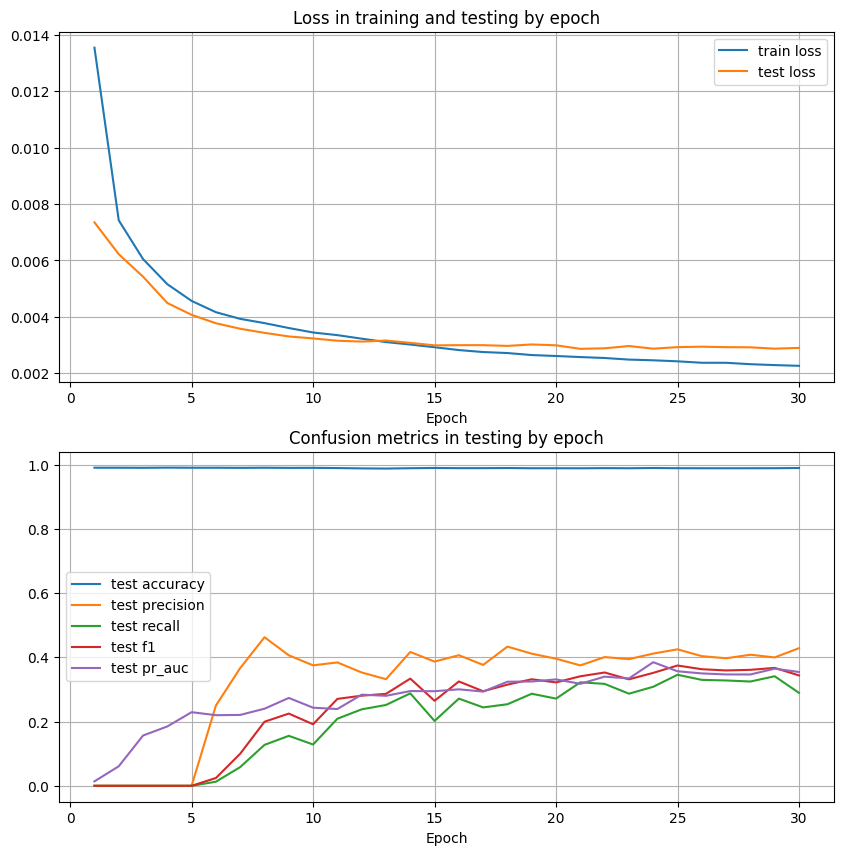

In [12]:
print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc", "pr_auc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Validation {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [13]:
os.makedirs(model_output_dir, exist_ok=True)
torch.save(model, f"{model_output_dir}/{pretrained_model_name}.pickle")

In [14]:

test_metrics = test_classifier(model, validation_dataset, device=device, batch_size=4096)

Testing: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


In [15]:
for metric in test_metrics.keys():
    if test_metrics[metric] is not None:
        print(f"Test {metric}:", test_metrics[metric])


Test loss: 0.0029194091912359
Test accuracy: 0.9854626782219738
Test precision: 0.3508771929824561
Test recall: 0.5714285714285714
Test f1: 0.43478260869565216
Test mcc: 0.4409596501022089
Test ece: 0.09924883395433426
Test pr_auc: 0.3576342581671703
